In [1]:
import requests
import base64
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import asyncio
import aiohttp

In [2]:
files = {
    'file': ('2310.01889v4.pdf', open('../stress-test/2310.01889v4.pdf', 'rb'), 'application/pdf'),
}

r = requests.post('http://localhost:7088/doc_layout', files=files)
r = r.json()
r['stats']

{'total_page': 16,
 'infer_time_taken': 0.904930830001831,
 'toimage_time_taken': 0.47612643241882324,
 'page_per_second': 17.680909379524206}

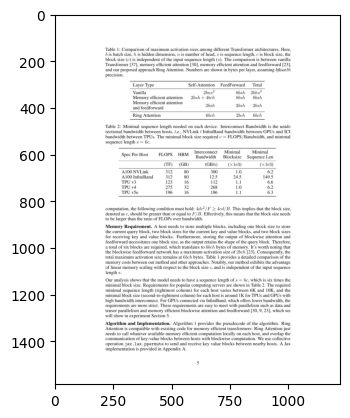

In [3]:
image_data = base64.b64decode(r['result'][4]['img'])
image = Image.open(BytesIO(image_data))
image_np = np.array(image)
plt.imshow(image_np)
plt.show()

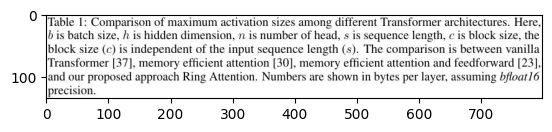

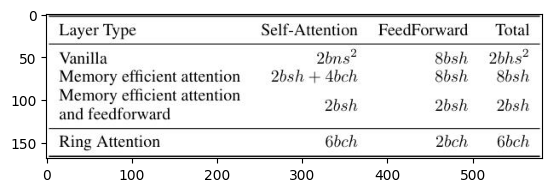

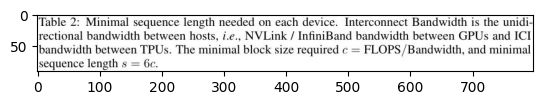

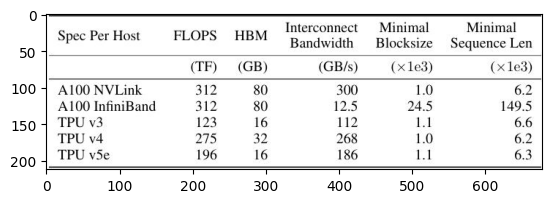

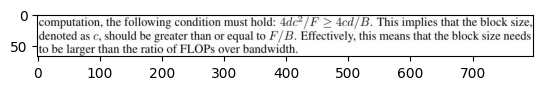

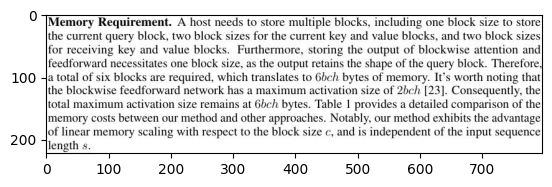

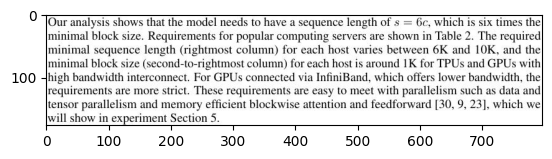

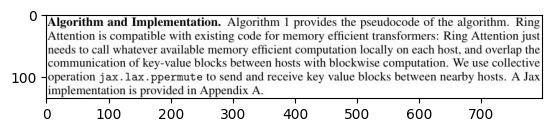

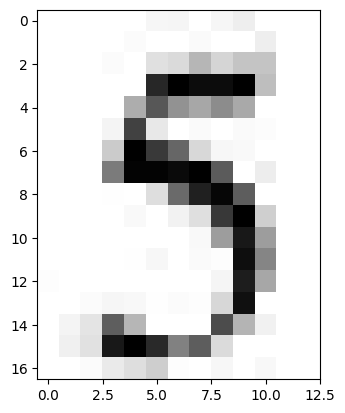

In [4]:
boxes = r['result'][4]['coordinates']
for i in range(len(boxes)):
    y_min = boxes[i]['y_min']
    y_max = boxes[i]['y_max']
    x_min = boxes[i]['x_min']
    x_max = boxes[i]['x_max']
    cropped_img = image_np[y_min:y_max, x_min:x_max]
    plt.imshow(cropped_img)
    plt.show()

In [5]:
images = []
boxes = r['result'][4]['coordinates']
for i in range(len(boxes)):
    y_min = boxes[i]['y_min']
    y_max = boxes[i]['y_max']
    x_min = boxes[i]['x_min']
    x_max = boxes[i]['x_max']
    cropped_img = image_np[y_min:y_max, x_min:x_max]
    images.append(cropped_img)

In [6]:
async def to_text(image):
    image = Image.fromarray(image)
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    buffer.seek(0)

    data_form = {
        'image': buffer,
        'mode': 'plain'
    }
    async with aiohttp.ClientSession() as session:
        async with session.post(
            'http://localhost:7088/ocr',
            data=data_form,
        ) as r:
            if r.status == 200:
                r = await r.json()
                return r

In [7]:
futures = [to_text(image) for image in images]
results = await asyncio.gather(*futures)

In [8]:
results

[{'result': ' Table 1: Comparison of maximum activation sizes among different Transformer architectures. Here,\n \\(b\\) is batch size, \\(h\\) is hidden dimension, \\(n\\) is number of head, \\(s\\) is sequence length, \\(c\\) is block size, the\n block size (c) is independent of the input sequence length \\((s)\\). The comparison is between vanilla\n Transformer [37], memory efficient attention [30], memory efficient attention and feedforward [23],\n and our proposed approach Ring Attention. Numbers are shown in bytes per layer, assuming bfloat16\n precision.'},
 {'result': '\\begin{tabular}{lccc}\n\\hline Layer Type & Self-Attention & FeedForward & Total \\\\\n\\hline Vanilla & \\(2 b n s^{2}\\) & \\(8 b s h\\) & \\(2 b h s^{2}\\) \\\\\nMemory efficient attention & \\(2 b s h+4 b c h\\) & \\(8 b s h\\) & \\(8 b s h\\) \\\\\nMemory efficient attention & \\(2 b s h\\) & \\(2 b s h\\) & \\(2 b s h\\) \\\\\nand feedforward & \\(6 b c h\\) & \\(2 b c h\\) & \\(6 b c h\\) \\\\\n\\hline Ri

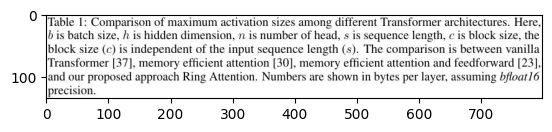

 Table 1: Comparison of maximum activation sizes among different Transformer architectures. Here,
 \(b\) is batch size, \(h\) is hidden dimension, \(n\) is number of head, \(s\) is sequence length, \(c\) is block size, the
 block size (c) is independent of the input sequence length \((s)\). The comparison is between vanilla
 Transformer [37], memory efficient attention [30], memory efficient attention and feedforward [23],
 and our proposed approach Ring Attention. Numbers are shown in bytes per layer, assuming bfloat16
 precision.


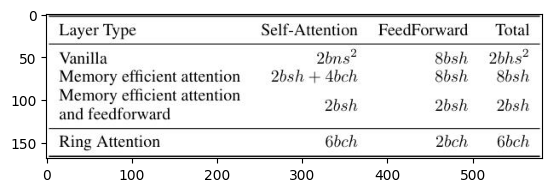

\begin{tabular}{lccc}
\hline Layer Type & Self-Attention & FeedForward & Total \\
\hline Vanilla & \(2 b n s^{2}\) & \(8 b s h\) & \(2 b h s^{2}\) \\
Memory efficient attention & \(2 b s h+4 b c h\) & \(8 b s h\) & \(8 b s h\) \\
Memory efficient attention & \(2 b s h\) & \(2 b s h\) & \(2 b s h\) \\
and feedforward & \(6 b c h\) & \(2 b c h\) & \(6 b c h\) \\
\hline Ring Attention & & &
\end{tabular}


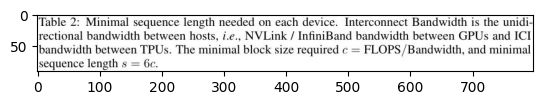

 Table 2: Minimal sequence length needed on each device. Interconnect Bandwidth is the unidi
rectional bandwidth between hosts, i.e., NVLink / InfiniBand bandwidth between GPUs and ICI
 bandwidth between TPUs. The minimal block size required \(c=\) FLOPS/Bandwidth, and minimal
 sequence length \(s=6 c\).


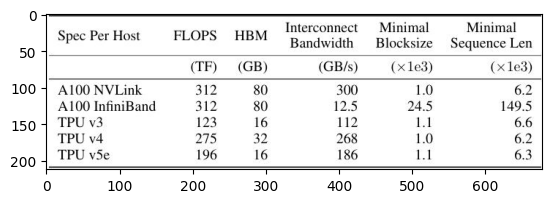

\begin{tabular}{lcccccc}
\hline Spec Per Host & FLOPS & HBM & \begin{tabular}{c} 
Interconnect \\
Bandwidth
\end{tabular} & \begin{tabular}{c} 
Minimal \\
Blocksize
\end{tabular} & \begin{tabular}{c} 
Minimal \\
Sequence Len
\end{tabular} \\
\hline & (TF) & (GB) & (GB/s) & \((\times 1 \mathrm{e} 3)\) & \((\times 1 \mathrm{e} 3)\) \\
\hline A100 NVLink & 312 & 80 & 300 & 1.0 & 6.2 \\
A100 InfiniBand & 312 & 80 & 12.5 & 24.5 & 149.5 \\
TPU v3 & 123 & 16 & 112 & 1.1 & 6.6 \\
TPU v4 & 275 & 32 & 268 & 1.0 & 6.2 \\
TPU v5e & 196 & 16 & 186 & 1.1 & 6.3 \\
\hline
\end{tabular}


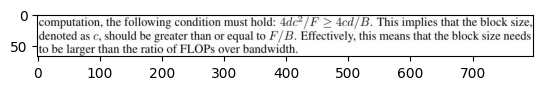

 computation, the following condition must hold: \(4 d c^{2} / F \geq 4 c d / B\). This implies that the block size,
 denoted as \(c\), should be greater than or equal to \(F / B\). Effectively, this means that the block size needs
 to be larger than the ratio of FLOPs over bandwidth.


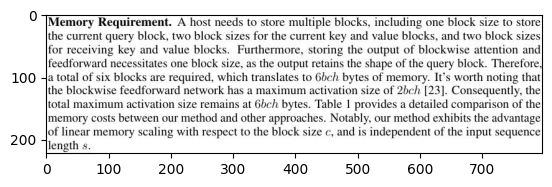

 Memory Requirement. A host needs to store multiple blocks, including one block size to store
 the current query block, two block sizes for the current key and value blocks, and two block sizes
 for receiving key and value blocks. Furthermore, storing the output of blockwise attention and
 feedforward necessitates one block size, as the output retains the shape of the query block. Therefore,
 a total of six blocks are required, which translates to \(6 b c h\) bytes of memory. It's worth noting that
 the blockwise feedforward network has a maximum activation size of \(2 b c h\) [23]. Consequently, the
 total maximum activation size remains at \(6 b c h\) bytes. Table 1 provides a detailed comparison of the
 memory costs between our method and other approaches. Notably, our method exhibits the advantage
 of linear memory scaling with respect to the block size \(c\), and is independent of the input sequence
 length \(s\).


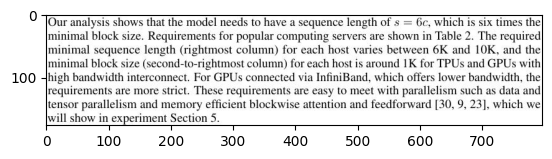

 Our analysis shows that the model needs to have a sequence length of \(s=6 c\), which is six times the
 minimal block size. Requirements for popular computing servers are shown in Table 2. The required
 minimal sequence length (rightmost column) for each host varies between \(6 \mathrm{~K}\) and \(10 \mathrm{~K}\), and the
 minimal block size (second-to-rightmost column) for each host is around \(1 \mathrm{~K}\) for TPUs and GPUs with
 high bandwidth interconnect. For GPUs connected via InfiniBand, which offers lower bandwidth, the
 requirements are more strict. These requirements are easy to meet with parallelism such as data and
 tensor parallelism and memory efficient blockwise attention and feedforward [30, 9, 23], which we
 will show in experiment Section 5.


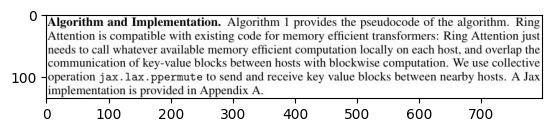

 Algorithm and Implementation. Algorithm 1 provides the pseudocode of the algorithm. Ring \(^{\text {T }}\)
 Attention is compatible with existing code for memory efficient transformers: Ring Attention just
 needs to call whatever available memory efficient computation locally on each host, and overlap the
 communication of key-value blocks between hosts with blockwise computation. We use collective
 operation jax. lax. ppermute to send and receive key value blocks between nearby hosts. A Jax
 implementation is provided in Appendix A.


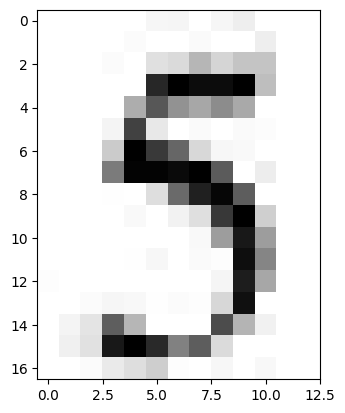

\text{5}


In [9]:
boxes = r['result'][4]['coordinates']
for i in range(len(boxes)):
    y_min = boxes[i]['y_min']
    y_max = boxes[i]['y_max']
    x_min = boxes[i]['x_min']
    x_max = boxes[i]['x_max']
    cropped_img = image_np[y_min:y_max, x_min:x_max]
    plt.imshow(cropped_img)
    plt.show()
    print(results[i]['result'])

In [11]:
async def to_text_plain(image):
    image = Image.fromarray(image)
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    buffer.seek(0)

    data_form = {
        'image': buffer,
        'mode': 'plain'
    }
    async with aiohttp.ClientSession() as session:
        async with session.post(
            'http://localhost:7088/ocr',
            data=data_form,
        ) as r:
            if r.status == 200:
                r = await r.json()
                return r
            
futures = [to_text_plain(image) for image in images]
results = await asyncio.gather(*futures)

In [12]:
results

[{'result': 'Table 1: Comparison of maximum activation sizes among different Transformer architectures. Here, \nb is batch size, h is hidden dimension, n is number of head, s is sequence length, c is block size, the \nblock size (c) is independent of the input sequence length (s). The comparison is between vanilla \nTransformer [37], memory efficient attention [30], memory efficient attention and feedforward [23], \nand our proposed approach Ring Attention. Numbers are shown in bytes per layer, assuming bfloat16 \nprecision.'},
 {'result': 'Layer Type Self- Attention Feed Forward Total Vanilla 2 b n s 2 8 b sh 2 b hs 2 Memory efficient attention 2 b sh+ 4 bch 8 b sh 8 b sh Memory efficient attention 2 b sh 2 b sh and feed forward Ring Attention 6 b ch 2 b ch 6 b ch'},
 {'result': 'Table 2: Minimal sequence length needed on each device. Interconnect Bandwidth is the unidi- \nrectional bandwidth between hosts, i.e., NVLink / InfiniBand bandwidth between GPUs and ICI \nbandwidth between T

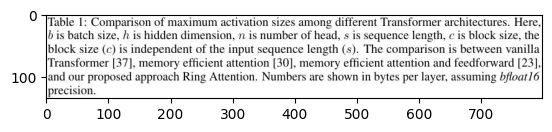

Table 1: Comparison of maximum activation sizes among different Transformer architectures. Here, 
b is batch size, h is hidden dimension, n is number of head, s is sequence length, c is block size, the 
block size (c) is independent of the input sequence length (s). The comparison is between vanilla 
Transformer [37], memory efficient attention [30], memory efficient attention and feedforward [23], 
and our proposed approach Ring Attention. Numbers are shown in bytes per layer, assuming bfloat16 
precision.


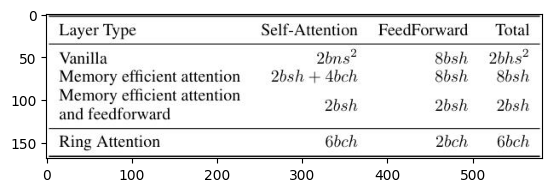

Layer Type Self- Attention Feed Forward Total Vanilla 2 b n s 2 8 b sh 2 b hs 2 Memory efficient attention 2 b sh+ 4 bch 8 b sh 8 b sh Memory efficient attention 2 b sh 2 b sh and feed forward Ring Attention 6 b ch 2 b ch 6 b ch


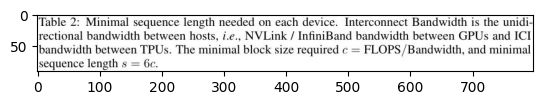

Table 2: Minimal sequence length needed on each device. Interconnect Bandwidth is the unidi- 
rectional bandwidth between hosts, i.e., NVLink / InfiniBand bandwidth between GPUs and ICI 
bandwidth between TPUs. The minimal block size required c = FLOPS/Bandwidth, and minimal 
sequence length s = 6c.


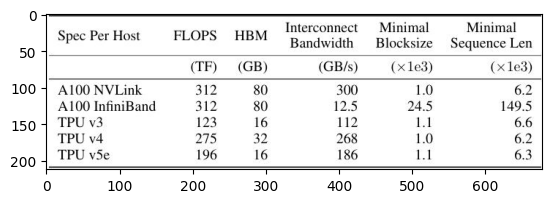

Interconnect Minimal Minimal SpecPerHost FLOPS HBM Bandwidth Blocksize SequenceLen (TF) (GB) (GB/s) (×1e3) (×1e3) A100NVLink 312 80 300 1.0 6.2 A100InfiniBand 312 80 12.5 24.5 149.5 TPUv3 123 16 112 1.1 6.6 TPUv4 275 32 268 1.0 6.2 TPUv5e 196 16 186 1.1 6.3


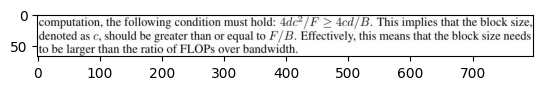

computation, the following condition must hold: 4dc2 / F ≥ 4cd / B. This implies that the block size,
denoted as c, should be greater than or equal to F / B. Effectively, this means that the block size needs
to be larger than the ratio of FLOPs over bandwidth.


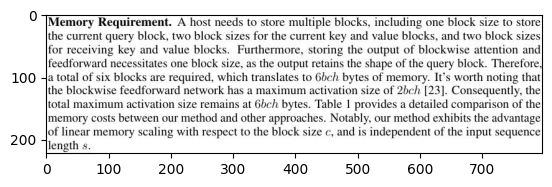

Memory Requirement. A host needs to store multiple blocks, including one block size to store
the current query block, two block sizes for the current key and value blocks, and two block sizes
for receiving key and value blocks. Furthermore, storing the output of blockwise attention and
feedforward necessitates one block size, as the output retains the shape of the query block. Therefore,
a total of six blocks are required, which translates to 6bch bytes of memory. It’s worth noting that
the blockwise feedforward network has a maximum activation size of 2bch [23]. Consequently, the
total maximum activation size remains at 6bch bytes. Table 1 provides a detailed comparison of the
memory costs between our method and other approaches. Notably, our method exhibits the advantage
of linear memory scaling with respect to the block size c, and is independent of the input sequence
length s.


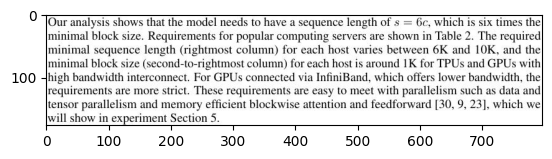

Our analysis shows that the model needs to have a sequence length of s = 6c, which is six times the
minimal block size. Requirements for popular computing servers are shown in Table 2. The required
minimal sequence length (rightmost column) for each host varies between 6K and 10K, and the
minimal block size (second-to-rightmost column) for each host is around 1K for TPUs and GPUs with
high bandwidth interconnect. For GPUs connected via InfiniBand, which offers lower bandwidth, the
requirements are more strict. These requirements are easy to meet with parallelism such as data and
tensor parallelism and memory efficient blockwise attention and feedforward [30, 9, 23], which we
will show in experiment Section 5.


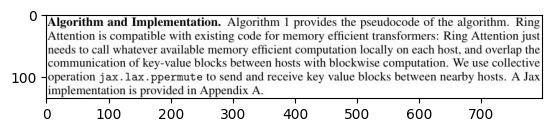

Algorithm and Implementation. Algorithm 1 provides the pseudocode of the algorithm. Ring
Attention is compatible with existing code for memory efficient transformers: Ring Attention just
needs to call whatever available memory efficient computation locally on each host, and overlap the
communication of key-value blocks between hosts with blockwise computation. We use collective
operation jax. lax. ppermute to send and receive key value blocks between nearby hosts. A Jax
implementation is provided in Appendix A.


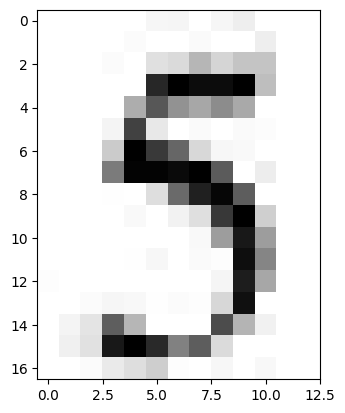

5


In [13]:
boxes = r['result'][4]['coordinates']
for i in range(len(boxes)):
    y_min = boxes[i]['y_min']
    y_max = boxes[i]['y_max']
    x_min = boxes[i]['x_min']
    x_max = boxes[i]['x_max']
    cropped_img = image_np[y_min:y_max, x_min:x_max]
    plt.imshow(cropped_img)
    plt.show()
    print(results[i]['result'])